In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

from collections import Counter

load dataset

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    data_dir='G:\data',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

showing examples

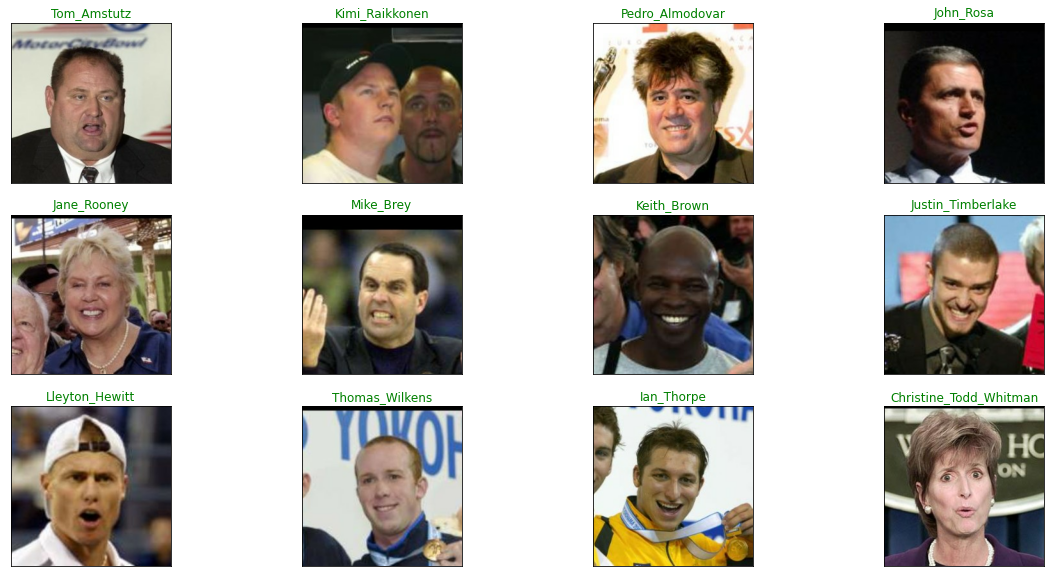

In [3]:
some_samples = [[x[1], x[0]] for x in iter(train_ds.take(12))]

fig = plt.figure(figsize=(20, 10))
for i in range(len(some_samples)):
  ax = fig.add_subplot(3, 4, i + 1)
  ax.imshow(some_samples[i][0])
  ax.set_title(some_samples[i][1].numpy().decode('utf-8'), c='g')
  plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
N = 10
BATCH_SIZE = 64
NUM_EPOCHS = 100

In [5]:
class SiameseNetworkDataset():
    
    '''Клас создания датасета для N лэйблов'''
    
    def __init__(self,train_ds=train_ds, N=N, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS):        
        self.train_ds = train_ds 
        self.N = N
        self.BATCH_SIZE = BATCH_SIZE
        self.NUM_EPOCHS = NUM_EPOCHS

    def get_name(self, train_ds, N):
        #  Получени N имен с самым большим количиством изображений
        train_ds_shape = tf.data.experimental.cardinality(train_ds).numpy()
        names_list = [x[0].numpy().decode('utf-8') for x in iter(train_ds.take(train_ds_shape))]
        most_common_names = Counter(names_list).most_common(N)
        
        most_common_names_list = []
        for name in most_common_names:
            most_common_names_list.append(name[0])
            
            
        MAP_SET = {}
        for iterations, names in enumerate(most_common_names_list):
            MAP_SET[names] =  iterations
        return most_common_names, most_common_names_list, MAP_SET
    
    def get_data_name(self, train_ds, N):
        # Выбор из датасета фотографий согласно списку
        most_common_names, most_common_names_list, MAP_SET = self.get_name(train_ds, N)
        
        lst_train_ds = list(train_ds.as_numpy_iterator())
        new_dataset_list = []
        for examples in tqdm(lst_train_ds):
            if examples[0].decode('utf8') in most_common_names_list:
                new_dataset_list.append(examples)
                
        for n in tqdm(range(len(new_dataset_list))):
            new_dataset_list[n] = list(new_dataset_list[n])
            new_dataset_list[n][0] = np.array(MAP_SET[new_dataset_list[n][0].decode('utf8')])
                
        train_x = new_dataset_list[0][1].reshape(-1, 250, 250, 3)
        train_y = [new_dataset_list[0][0]]
        for imgs in tqdm(new_dataset_list[1:]):
            train_x = np.vstack((train_x, imgs[1].reshape(-1, 250, 250, 3)))
            train_y.append(imgs[0])
        return train_x, train_y
            
            
    def dataset_processing(self, train_ds, N, BATCH_SIZE, NUM_EPOCHS):
        # Сборка датасета
        train_x, train_y = self.get_data_name(train_ds, N)
        
        train_y = np.array(train_y)
        train_x = train_x.astype(np.float32) / 255.
        
        train_df = tf.data.Dataset.from_tensor_slices((train_x, train_y))
        train_df = train_df.shuffle(buffer_size=train_x.shape[0])
        train_df = train_df.repeat(NUM_EPOCHS)
        train_df = train_df.batch(BATCH_SIZE)
        
        return train_df, train_x, train_y


In [6]:
SND = SiameseNetworkDataset()

In [7]:
train_ds, train_x, train_y = SND.dataset_processing(train_ds, N, BATCH_SIZE, NUM_EPOCHS)

In [8]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [9]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [10]:

MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [11]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 82.6805419921875
[50] Loss: 14.892149925231934
[100] Loss: 14.305423736572266
[150] Loss: 16.24635124206543
[200] Loss: 8.428214073181152
[250] Loss: 17.368717193603516
[300] Loss: 19.84081268310547
[350] Loss: 15.34561824798584
[400] Loss: 15.93218994140625
[450] Loss: 11.367931365966797
[500] Loss: 9.475631713867188
[550] Loss: 6.489812850952148
[600] Loss: 10.002131462097168
[650] Loss: 6.243892669677734
[700] Loss: 6.734581470489502
[750] Loss: 6.477587699890137
[800] Loss: 9.281925201416016
[850] Loss: 5.980999946594238
[900] Loss: 4.558689117431641
[950] Loss: 8.92231559753418
[1000] Loss: 1.6134729385375977
[1050] Loss: 7.0651774406433105
[1100] Loss: 3.628523826599121
[1150] Loss: 2.09869647026062
[1200] Loss: 4.805546283721924
[1250] Loss: 3.8273282051086426
[1300] Loss: 2.3029606342315674
[1350] Loss: 2.620004653930664
[1400] Loss: 1.0552178621292114
[1450] Loss: 1.7419791221618652
[1500] Loss: 2.218116044998169
[1550] Loss: 2.3273096084594727
[1600] Loss: 1.5817408

In [12]:
embs = model(train_x[:200])

In [13]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [14]:
test_x_flat = train_x.reshape(-1, 250*250*3)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:200])
labels_for_viz = train_y[:200]

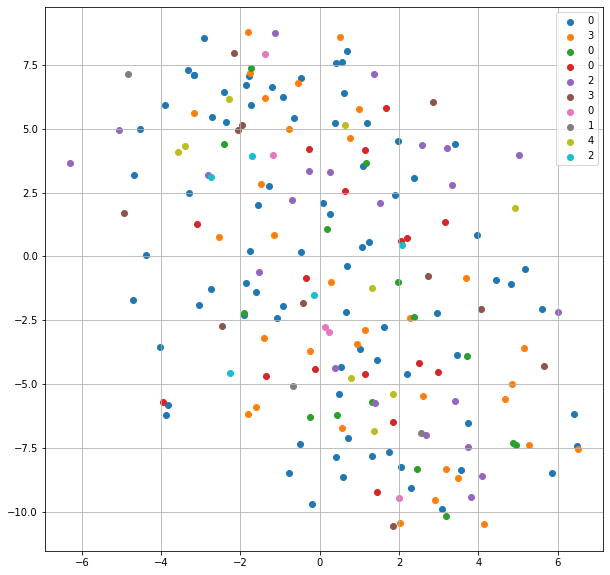

In [15]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(N))

In [16]:
test_embs_2D = TSNE(n_components=2).fit_transform(embs)
labels_for_viz = train_y[:200]

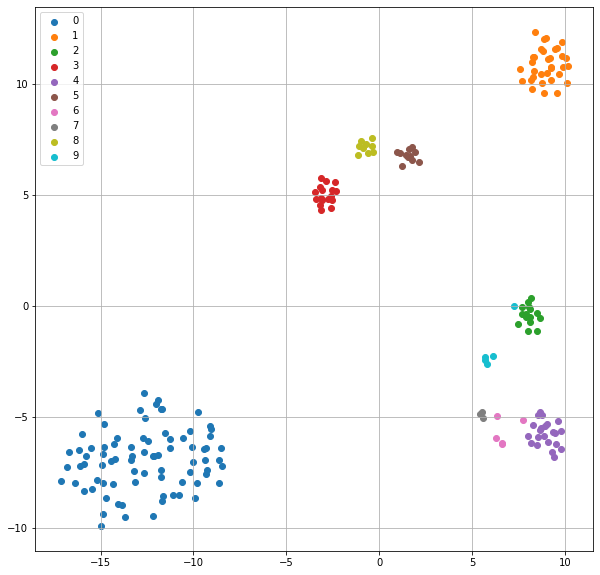

In [17]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(N)))